In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import asc, desc

In [4]:
# create engine to hawaii.sqlite
database_path = "Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
#grab first row of data from Measurment table
first_row = session.query(Measurement).first()
first_row.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2ba630bb670>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08}

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f'The most recent date is: {recent_date[0]}')

The most recent date is: 2017-08-23


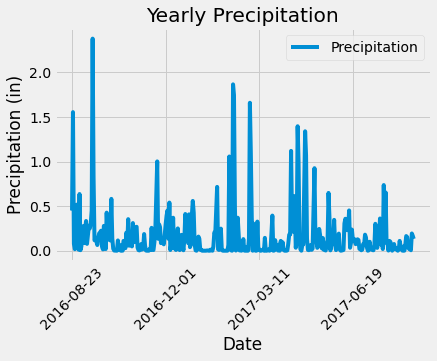

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
date_minus_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
date_minus_year #datetime.date(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, func.avg(Measurement.prcp)).filter(Measurement.date.between (date_minus_year, dt.date(2017, 8, 23))).group_by('date')

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(data, columns = ["Date", "Precipitation"])
prcp_df.set_index("Date", inplace=True)

# Sort the dataframe by date
prcp_df.sort_values(by="Date")
# prcp_df

# Use Pandas Plotting with Matplotlib to plot the dates
prcp_df.plot(rot = 45)
plt.xlabel("Date")
plt.ylabel("Precipitation (in)")
plt.title("Yearly Precipitation")
plt.show()



In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
round(prcp_df.describe(),2)

,Precipitation
count,366.00
mean,0.17
std,0.30
min,0.00
25%,0.01
50%,0.07
75%,0.19
max,2.38


# Exploratory Station Analysis

In [13]:
##grab first row of data from Station table
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2ba668e47f0>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'elevation': 3.0}

In [14]:
# Design a query to calculate the total number stations in the dataset
count = session.query(Station).count()
print(f'There are {count} station in the dataset.')

There are 9 station in the dataset.


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                .join(Station, Station.station == Measurement.station).order_by(func.count(Measurement.station).desc())\
                .group_by(Measurement.station)
# most_active_stations;
for station in active_stations:
    print(station)

print(f'The most active stations is: {active_stations[0][0]}, with {active_stations[0][1]} rows')

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)
The most active stations is: USC00519281, with 2772 rows


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_avg = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
                          .filter(Measurement.station == active_stations[0][0]).all()

print (f'Station: {active_stations[0][0]}')
print (f'Max Temp: {round(active_station_avg[0][1],2)}')
print (f'Min Temp: {round(active_station_avg[0][0],2)}')
print (f'Avg Temp: {round(active_station_avg[0][2],2)}')

Station: USC00519281
Max Temp: 85.0
Min Temp: 54.0
Avg Temp: 71.66


In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_year_data = session.query(Measurement.date, Measurement.tobs)\
                .filter(Measurement.station == active_stations[0][0], Measurement.date.between(date_minus_year, dt.date(2017, 8, 23)))\
                .group_by(Measurement.date)\
                .order_by(Measurement.date)

avtive_station_temp_df = pd.DataFrame(active_station_year_data, columns = ["Date", "Temperature"])
avtive_station_temp_df.set_index("Date", inplace=True)
avtive_station_temp_df

,Temperature
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


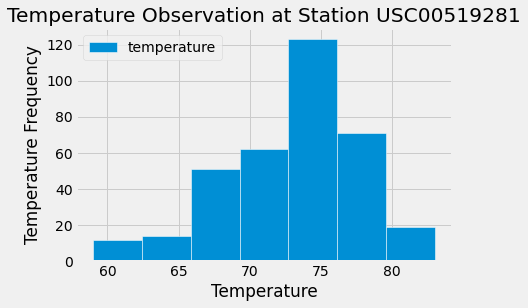

In [19]:
plt.xlabel('Temperature')
plt.ylabel('Temperature Frequency')
plt.title(f'Temperature Observation at Station {active_stations[0][0]}')
plt.hist(avtive_station_temp_df, bins=7, alpha=1, label='temperature', edgecolor='w')
plt.legend()

# Close session

In [20]:
# Close Session
session.close()